In [103]:
# So we can import our modules
import sys

sys.path.append("../..")

from typing import Optional, Union
import os
import warnings
import json
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from captum.attr import visualization as viz
from ultralytics import YOLO
import torch

### Analysis of results

In [104]:
df = pd.read_csv("../../results/pornography-2k/cnns/data-aug/even-20/explanations/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20/correct/IG/faces/results.csv")
df

,frame,box,conf,area,perc,attr
0,vNonPorn000080#17.jpg,NaN,NaN,NaN,NaN,NaN
1,vNonPorn000928#2.jpg,NaN,NaN,NaN,NaN,NaN
2,vPorn000430#15.jpg,NaN,NaN,NaN,NaN,NaN
3,vNonPorn000733#19.jpg,NaN,NaN,NaN,NaN,NaN
4,vPorn000303#10.jpg,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
41356,vNonPorn000502#2.jpg,NaN,NaN,NaN,NaN,NaN
41357,vNonPorn000214#5.jpg,NaN,NaN,NaN,NaN,NaN
41358,vNonPorn000037#7.jpg,NaN,NaN,NaN,NaN,NaN
41359,vNonPorn000246#16.jpg,NaN,NaN,NaN,NaN,NaN


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   frame   41360 non-null  object 
 1   box     4777 non-null   object 
 2   conf    4777 non-null   float64
 3   area    4777 non-null   float64
 4   perc    4777 non-null   float64
 5   attr    4539 non-null   float64
dtypes: float64(4), object(2)
memory usage: 1.9+ MB


In [106]:
df[(df["attr"] > 50) & df["frame"].str.contains("vPorn")].sort_values(by="attr", ascending=False)

,frame,box,conf,area,perc,attr
14320,vPorn000076#18.jpg,"(54.0, 5.0, 206.0, 202.0)",0.57495,29944.0,59.677934,73.193731
28909,vPorn000055#4.jpg,"(0.0, 12.0, 156.0, 224.0)",0.58754,33072.0,65.911990,71.081976
38402,vPorn000610#1.jpg,"(26.0, 5.0, 167.0, 209.0)",0.54569,28764.0,57.326212,68.818802
38089,vPorn000106#10.jpg,"(57.0, 6.0, 196.0, 165.0)",0.65192,22101.0,44.046955,68.038661
30050,vPorn000492#18.jpg,"(64.0, 4.0, 209.0, 211.0)",0.52417,30015.0,59.819436,67.447851
28130,vPorn000746#6.jpg,"(40.0, 30.0, 167.0, 198.0)",0.66251,21336.0,42.522321,63.915247
15440,vPorn000492#16.jpg,"(88.0, 3.0, 205.0, 223.0)",0.70773,25740.0,51.299426,61.312530
7436,vPorn000538#9.jpg,"(45.0, 0.0, 154.0, 178.0)",0.78335,19402.0,38.667889,58.808299
21912,vPorn000081#19.jpg,"(53.0, 19.0, 210.0, 196.0)",0.50403,27789.0,55.383052,55.943876
487,vPorn000848#13.jpg,"(0.0, 7.0, 78.0, 200.0)",0.73836,15054.0,30.002392,54.473509


### Privacy-preserving explanations

In [155]:
DATA_LOC = "/nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20"
# EXPLANATIONS_LOC = "../../results/pornography-2k/cnns/data-aug/even-20/explanations/vgg19_freeze_False_epochs_50_batch_16_optim_sgd_aug_True_split_10_20/correct/IG/npys"
EXPLANATIONS_LOC = "../../results/pornography-2k/transformers/no-freeze/even-20/explanations/vit_base_patch16_224_epochs_50_batch_16_optim_sgd_aug_False_split_10_20/npys"

In [156]:
# Source: https://github.com/pytorch/captum/blob/master/captum/attr/_utils/visualization.py
def normalize_scale(attr: np.ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


# Source: https://github.com/pytorch/captum/blob/master/captum/attr/_utils/visualization.py
def cumulative_sum_threshold(values: np.ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


# Source: https://github.com/pytorch/captum/blob/master/captum/attr/_utils/visualization.py
def normalize_attr(
    attr: np.ndarray,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    attr_combined = (attr_combined > 0) * attr_combined
    threshold = cumulative_sum_threshold(attr_combined, 100 - outlier_perc)

    return normalize_scale(attr_combined, threshold)

In [157]:
def calculate_attribution_in_box(attr, box_coords):
    x1, y1, x2, y2 = box_coords
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    total_attr = np.sum(attr)
    box_attr = attr[y1:y2, x1:x2]
    total_box_attr = np.sum(box_attr)

    return (total_box_attr / total_attr) * 100


def blur_box(image, box_coords):
    x1, y1, x2, y2 = box_coords
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    roi = image[y1:y2, x1:x2]
    if len(roi) == 0:
        return
    KSIZE, SIGMA = (9, 9), 15
    roi = cv2.GaussianBlur(roi, KSIZE, SIGMA)

    image[y1:y2, x1:x2] = roi


def show_blurred_explanation(image, attr):
    METHOD = "blended_heat_map"
    SIGN = "positive"
    COLORMAP = "jet"

    viz.visualize_image_attr_multiple(
        attr=attr,
        original_image=image,
        methods=["original_image", METHOD],
        signs=["all", SIGN],
        cmap=COLORMAP,
    )

In [158]:
CONF_THRES = 0.5
model = YOLO(model="../../yolov8n-face.pt")

In [159]:
INPUT_SHAPE = 224
H = W = INPUT_SHAPE
IMG_AREA = H * W

data_transforms = A.Resize(height=H, width=W)

In [160]:
def generate_privacy_preserving_explanation(img_name):
    print("YOLO face detection with explanation anonymization")

    result = model.predict(source=f"{DATA_LOC}/{img_name}", conf=CONF_THRES)[0]
    result.show()

    # load original image
    img_file = os.path.join(DATA_LOC, img_name)
    assert os.path.isfile(img_file), "Invalid image path"

    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h_orig, w_orig, _ = img.shape
    print("Image original shape:", img.shape)

    img = data_transforms(image=img)["image"]
    print("Transformed image shape:", img.shape)

    # load explanation
    attr_file = os.path.join(EXPLANATIONS_LOC, os.path.splitext(img_name)[0] + ".npy")
    assert os.path.isfile(attr_file), "Invalid explanation path"

    attr_np = np.load(attr_file)
    if attr_np.shape[0] in (3, 4): attr_np = np.transpose(attr_np, (1, 2, 0)) # CHW -> HWC
    attr_np = normalize_attr(attr_np)
    if len(attr_np.shape) == 2: attr_np = np.expand_dims(attr_np, axis=-1)
    print("Attribution shape:", attr_np.shape)

    assert img.shape[:2] == attr_np.shape[:2], "Image and attribution shapes must match"

    h_ratio, w_ratio = H / h_orig, W / w_orig

    adjusted_boxes = torch.clone(result.boxes.data)
    adjusted_boxes[:, 0] = torch.round(adjusted_boxes[:, 0] * w_ratio)
    adjusted_boxes[:, 1] = torch.round(adjusted_boxes[:, 1] * h_ratio)
    adjusted_boxes[:, 2] = torch.round(adjusted_boxes[:, 2] * w_ratio)
    adjusted_boxes[:, 3] = torch.round(adjusted_boxes[:, 3] * h_ratio)
    result.update(boxes=adjusted_boxes)
    print("\nResult (x1, y1, x2, y2, conf, cls):\n", result.boxes.data, "\n")

    for box in result.boxes.data:
        x1, y1, x2, y2, _, _ = box
        area = (x2 - x1) * (y2 - y1)
        perc = (area / IMG_AREA) * 100
        attr = calculate_attribution_in_box(attr_np, (x1, y1, x2, y2))

        if area != 0:
            blur_box(img, (x1, y1, x2, y2))

        print("Area:", area.item())
        print("Perc (%):", perc.item())
        print("Attr (%):", attr)

    show_blurred_explanation(img, attr_np)

YOLO face detection with explanation anonymization

image 1/1 /nas-ctm01/datasets/public/BIOMETRICS/pornography-2k-db/data-processed/even-20/vPorn000076#18.jpg: 480x640 2 faces, 77.5ms
Speed: 5.0ms preprocess, 77.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
c 0
c 0


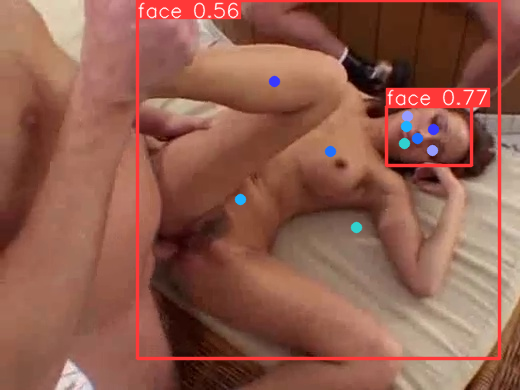

Image original shape: (390, 520, 3)
Transformed image shape: (224, 224, 3)
Attribution shape: (224, 224, 1)

Result (x1, y1, x2, y2, conf, cls):
 tensor([[166.0000,  61.0000, 203.0000,  95.0000,   0.7685,   0.0000],
        [ 59.0000,   0.0000, 215.0000, 206.0000,   0.5592,   0.0000]]) 

Area: 1258.0
Perc (%): 2.5071747303009033
Attr (%): 3.7440646439790726
Area: 32136.0
Perc (%): 64.04655456542969
Attr (%): 62.7832293510437


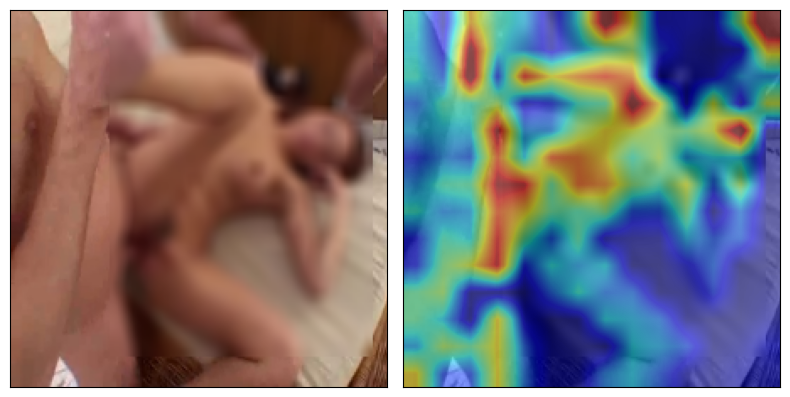

In [161]:
generate_privacy_preserving_explanation("vPorn000076#18.jpg")